In [77]:
import pandas as pd
import pandas_profiling
import matplotlib.pyplot as plt
import seaborn as sns

import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.metrics import roc_auc_score
from category_encoders import TargetEncoder
from xgboost import XGBRegressor

In [7]:
# Load train/test data
train = pd.read_csv('data/challenge3_train.csv', index_col='id').reset_index()
test = pd.read_csv('data/challenge3_test.csv', index_col='id').reset_index()
# Combine for exploration
data = pd.concat([train, test])
data = data.drop(['target'], axis=1)
print(f'train: {train.shape} | test: {test.shape}, all: {data.shape}')
train.head(2) # Look at a small sample to get a overview

train: (50000, 33) | test: (50000, 32), all: (100000, 32)


,id,target,f0,f1,f2,f3,f4,f5,f6,f7,...,f21,f22,f23,f24,f25,f26,f27,f28,f29,f30
0,0,1,0.0,5.0,0.0,4.0,3598.0,M,3.0,-7.2430,...,3.0,14.2364,0.0,NaN,4.0,1.0,5.0,PS,2.0,0.834041
1,1,0,NaN,5.0,4.0,NaN,2072.0,NaN,4.0,-1.6662,...,3.0,NaN,2.0,3.0,NaN,1.0,5.0,DT,5.0,0.686021


In [8]:
# Generate reports
#pandas_profiling.ProfileReport(train, minimal=False) #.to_file('train_report.html')
#pandas_profiling.ProfileReport(test, minimal=False) #.to_file('test_report_small.html')
#pandas_profiling.ProfileReport(data, minimal=True) #.to_file('data_report.html')

# Report for 1/0 class
#pandas_profiling.ProfileReport(train[train['target'] == 1], minimal=False) #.to_file('train_1_report.html')
#pandas_profiling.ProfileReport(train[train['target'] == 0], minimal=False) #.to_file('train_0_report.html')

In [9]:
# Helper lists for column types
features_bin = ['f0', 'f26'] # binary
features_nom_low = ['f5'] # nominal low cardinality (<=3)
features_nom_high = ['f12', 'f28'] # >= 26
features_ord_low = ['f1', 'f2', 'f3', 'f6', 'f9', 'f11', 'f13', 'f15', 'f17', 'f18', 'f19', 'f20', 'f21', 'f23', 'f24', 'f25', 'f27', 'f29']
features_ord_num = ['f1', 'f2', 'f3', 'f6', 'f9', 'f11', 'f13', 'f17', 'f18', 'f19', 'f21', 'f23', 'f24', 'f25', 'f27', 'f29']
features_ord_high = ['f4', 'f10', 'f14']
features_real = ['f7', 'f8', 'f16', 'f22', 'f30'] # real numbers.

Percentage of feature values being NaN


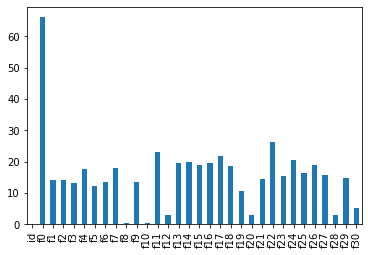

In [10]:
# We look at how many values are nan:
print('Percentage of feature values being NaN')
nans = data.isna().sum().map(lambda x: x / len(data) * 100).round(1).plot(kind='bar')

In [12]:
# We look at unique values for each column
for column in data.columns:
    unique = data[column].unique()
    count = len(unique)
    print('Column', column)
    print('Values:', unique)
    print('Number of unique:', count)
    print('\n')

Column id
Values: [    0     1     2 ... 99997 99998 99999]
Number of unique: 100000


Column f0
Values: [ 0. nan  1.]
Number of unique: 3


Column f1
Values: [ 5.  1. nan  2.  3.  4.  0.]
Number of unique: 7


Column f2
Values: [ 0.  4.  2. nan  3.  5.  1.]
Number of unique: 7


Column f3
Values: [ 4. nan  2.  1.  3.  5.  0.]
Number of unique: 7


Column f4
Values: [3598. 2072.  862. ... 1261. 1257.  518.]
Number of unique: 3768


Column f5
Values: ['M' nan 'F']
Number of unique: 3


Column f6
Values: [ 3.  4.  5. nan  1.  0.  2.]
Number of unique: 7


Column f7
Values: [ -7.243   -1.6662  -0.12   ...  -6.8409  -5.4951 -10.1088]
Number of unique: 67092


Column f8
Values: [13.9681 14.0242 14.2174 ... 13.803  14.6088 13.8286]
Number of unique: 8176


Column f9
Values: [ 3.  0.  1.  5. nan  2.  4.]
Number of unique: 7


Column f10
Values: [0.000e+00 3.200e+01 5.000e+00 8.400e+01 1.200e+01 1.700e+01 1.900e+01
 5.240e+02 1.100e+01 2.200e+01 3.800e+01 4.500e+01 3.000e+00 2.000e+00
 6.000e+

Distribution of unique values and Nan:
Column f0


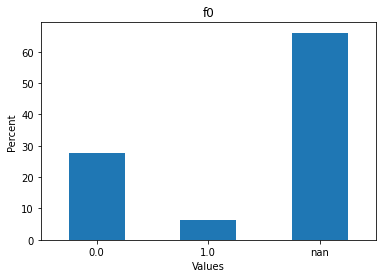

Column f1


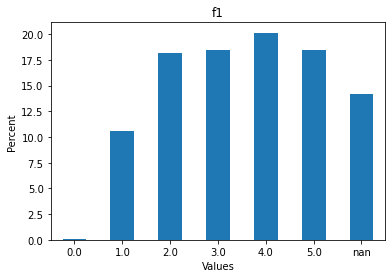

Column f2


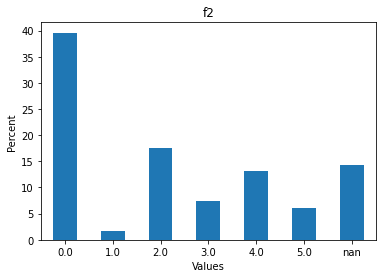

Column f3


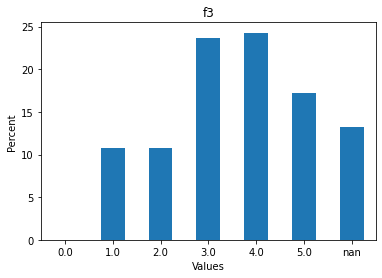

Column f5


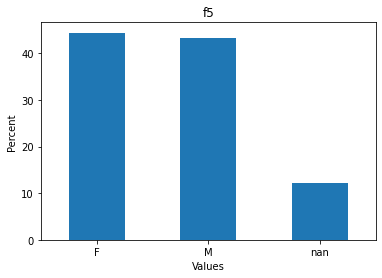

Column f6


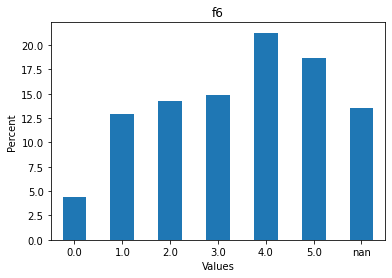

Column f9


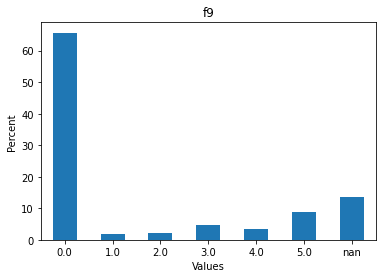

Column f11


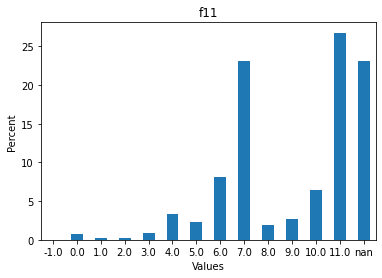

Column f15


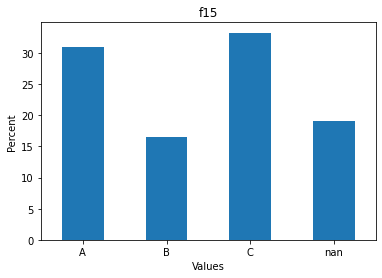

Column f17


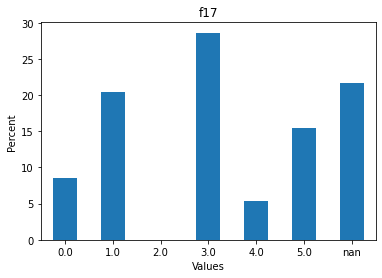

Column f18


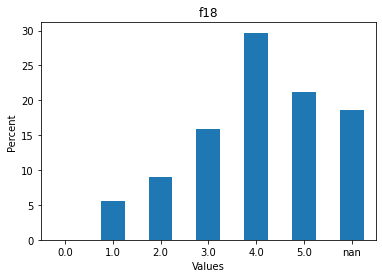

Column f19


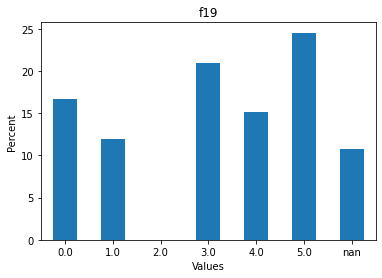

Column f20


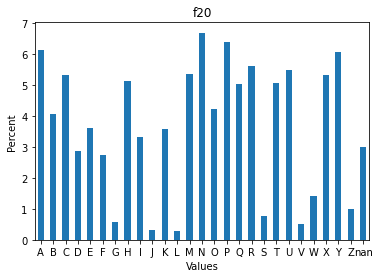

Column f21


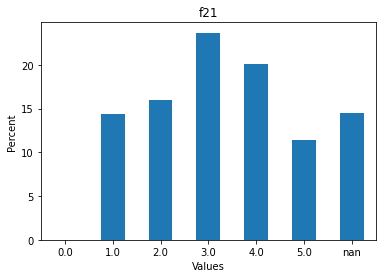

Column f23


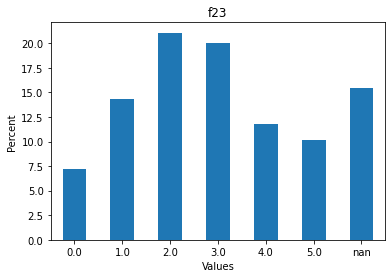

Column f24


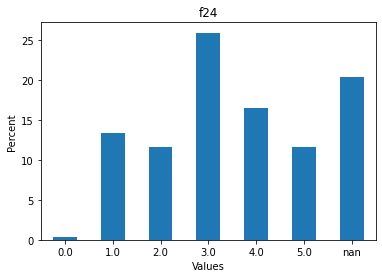

Column f25


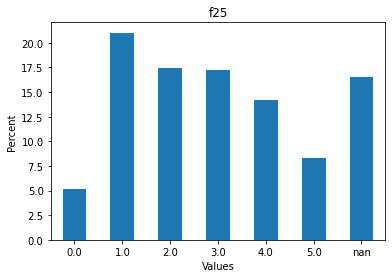

Column f26


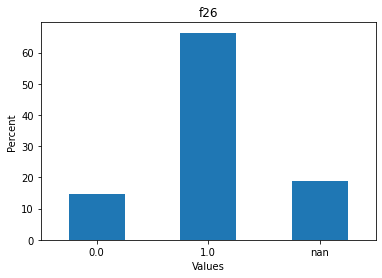

Column f27


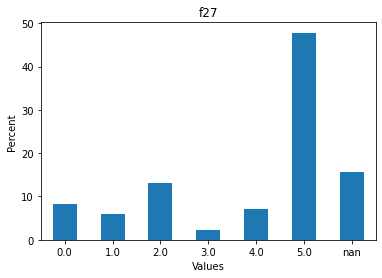

Column f29


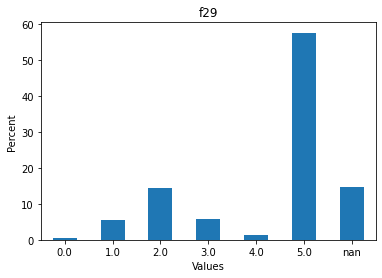

In [21]:
print('Distribution of unique values and Nan:')      
for column in data.columns:
    count = len(data[column].unique())
    if count > 30:
        continue # Too many values to compute/display graph on
    value_percent = data[column].value_counts(dropna=False, sort=False).map(lambda x: x / len(data[column]) * 100).sort_index()
    print('Column', column)
    
    ax = value_percent.plot.bar(rot=0)
    ax.set_title(column)
    plt.ylabel('Percent')
    plt.xlabel('Values')
    plt.show()

## From the graphs we see the following
We have nan's in all columns, in widely varying degrees. 

Graphs with zero (0) as noise, meaning we could look into dropping them:
f1, f3, f18, f21, f24, f29

f11 have noise in -1, in addition to 0.

f17, f19 have only 0.002% and 0.001% '2' value counts

In [22]:
# From above we want to explore the columns with 0 as possible noise:
zero_columns = ['f1', 'f3', 'f11', 'f18', 'f21', 'f24', 'f29']
print('Look into zero values in train and test set')
for column in zero_columns:
    print('\n', column)
    print('Zero value in feature grouped by target:')
    print(train.loc[train[column] == 0].groupby([column, 'target']).size())
    print('\n')
    print('Zero value count in train vs test set')
    print('train:', train.loc[train[column] == 0].shape[0])
    print('test :', test.loc[test[column] == 0].shape[0])
    
    if (column == 'f11'):
        print('\n')
        print(train.loc[train[column] == -1].groupby([column, 'target']).size())
        print('train:', train.loc[train['f11'] == -1].shape[0])
        print('test :', test.loc[test['f11'] == -1].shape[0])

print('We see 0 value can be removed/changed safely from f3, f18, f21')

Look into zero values in train and test set

 f1
Zero value in feature grouped by target:
f1   target
0.0  0         30
     1         16
dtype: int64


Zero value count in train vs test set
train: 46
test : 48

 f3
Zero value in feature grouped by target:
f3   target
0.0  0         1
dtype: int64


Zero value count in train vs test set
train: 1
test : 0

 f11
Zero value in feature grouped by target:
f11  target
0.0  0         217
     1         154
dtype: int64


Zero value count in train vs test set
train: 371
test : 379


f11   target
-1.0  0         4
      1         2
dtype: int64
train: 6
test : 6

 f18
Zero value in feature grouped by target:
Series([], dtype: int64)


Zero value count in train vs test set
train: 0
test : 1

 f21
Zero value in feature grouped by target:
Series([], dtype: int64)


Zero value count in train vs test set
train: 0
test : 1

 f24
Zero value in feature grouped by target:
f24  target
0.0  0         119
     1          78
dtype: int64


Zero value count 

Check out real values train/test


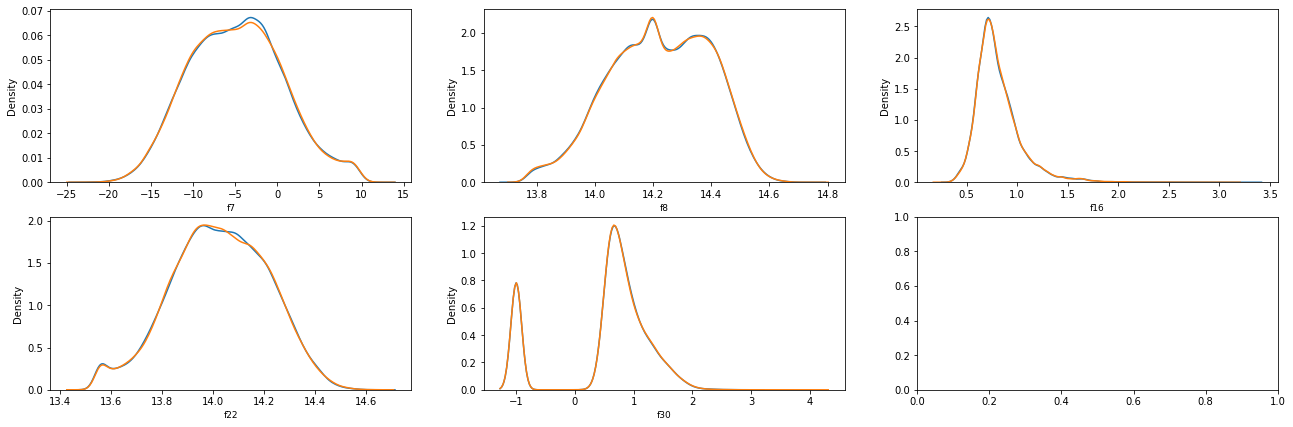

We see they are similar


In [31]:
# We want to see how the distribution for real values are in test and trainng set, if they are different.
print('Check out real values train/test')
fig, ax = plt.subplots(2,3,figsize=(22,7))
for i, col in enumerate(features_real):
    plt.subplot(2,3,i+1)
    plt.xlabel(col, fontsize=9)
    sns.kdeplot(train[col].values,label='Train')
    sns.kdeplot(test[col].values,label='Test')
   
plt.show() 
print('We see they are similar')

Real number columns, train targets


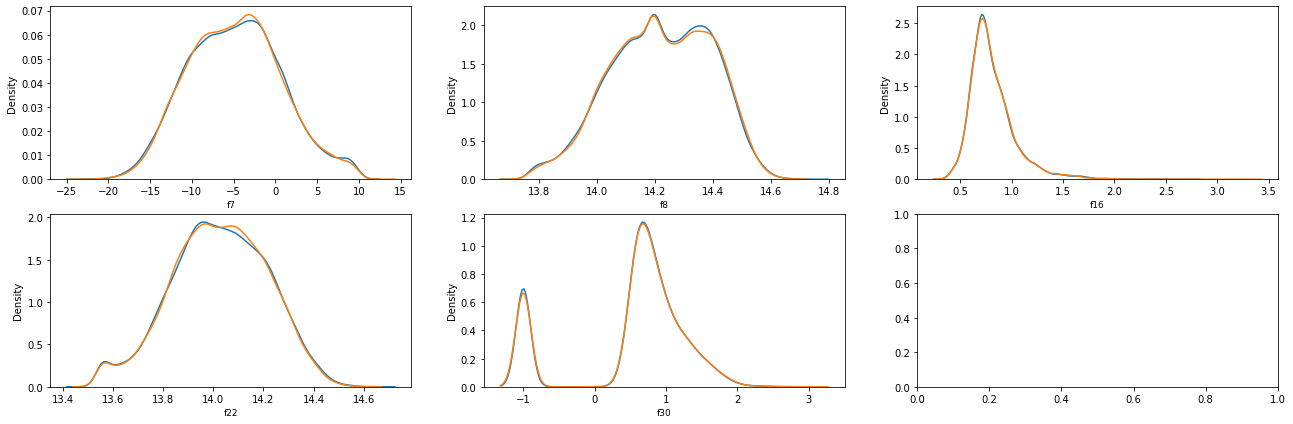

We see basically no difference between train targets


In [27]:
# look at real numbers columns
print('Real number columns, train targets')

target0 = train.loc[train['target'] == 0]
target1 = train.loc[train['target'] == 1]

fig, ax = plt.subplots(2,3,figsize=(22,7))
for i, col in enumerate(features_real):
    plt.subplot(2,3,i+1)
    plt.xlabel(col, fontsize=9)
    sns.kdeplot(target0[col].values, label='Target: 0')
    sns.kdeplot(target1[col].values, label='Target: 1')
    #sns.kdeplot(test[col].values, label='Test')

plt.show()
print('We see basically no difference between train targets')

Rolling mean for real values


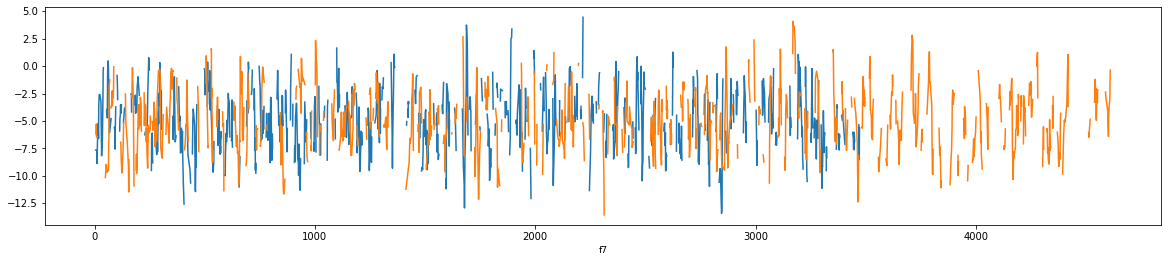

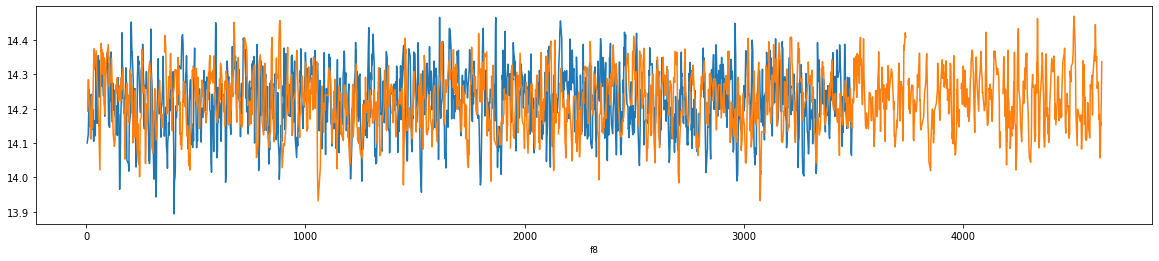

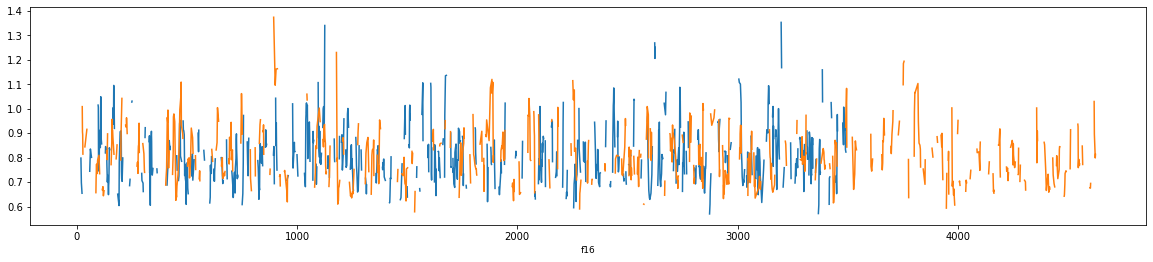

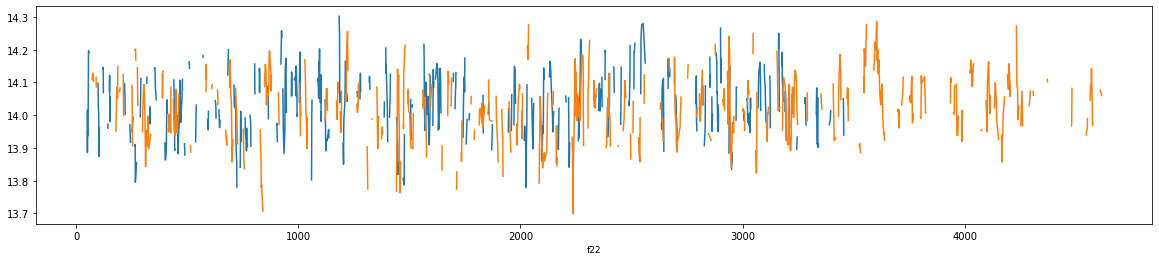

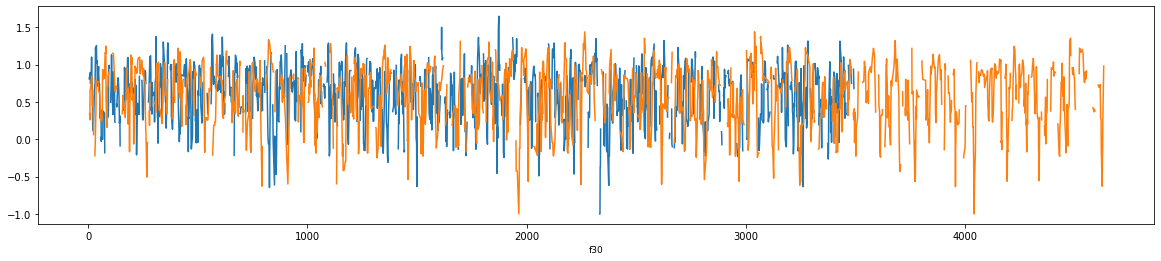

We see f8 seem to have continous variables.


In [75]:
# We want to see how the real interact in the dataset, if there is a tendency. 
print('Rolling mean for real values')
for col in features_real:
    plt.figure(figsize=(20, 4)) 

    target0[col][:2000].rolling(4).mean().plot()
    target1[col][:2000].rolling(4).mean().plot()

    #test[col][:2000].rolling(2).mean().plot()

    plt.xlabel(col, fontsize=9)

    plt.show()
print('We see f8 seem to have continous variables.')

<Figure size 1224x2520 with 0 Axes>

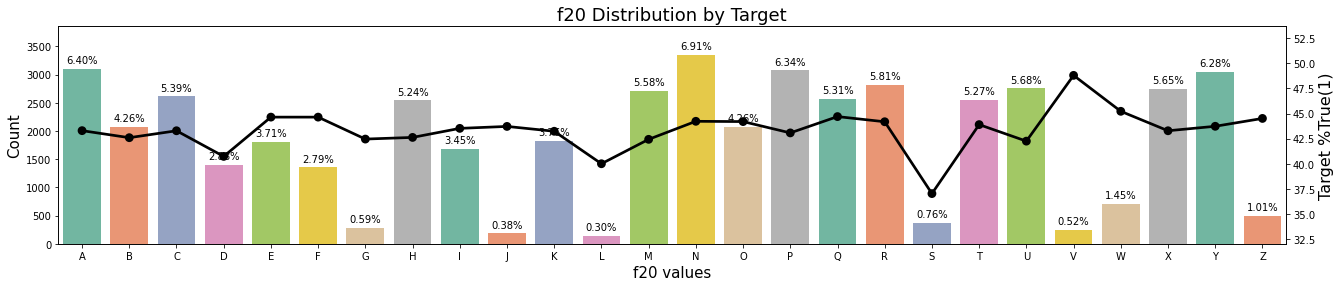

There is not much to gain here. 's' has fewer target 1's.


In [48]:
# creds: https://www.kaggle.com/warkingleo2000/first-step-on-kaggle
# We want to see if there is a tendency in the alphabet feature, f20
ord_cols = ['f20']
plt.figure(figsize=(17, 35)) 
fig, ax = plt.subplots(1,1,figsize=(22,10))

for i, col in enumerate(train[ord_cols]): 
    tmp = pd.crosstab(train[col], train['target'], normalize='index') * 100
    tmp = tmp.reset_index()
    tmp.rename(columns={0:'No',1:'Yes'}, inplace=True)

    ax = plt.subplot(2,1,i+1)
    sns.countplot(x=col, data=train, order=list(tmp[col].values) , palette='Set2') 
    ax.set_ylabel('Count', fontsize=15) # y axis label
    ax.set_title(f'{col} Distribution by Target', fontsize=18) # title label
    ax.set_xlabel(f'{col} values', fontsize=15) # x axis label

    # twinX - to build a second yaxis
    gt = ax.twinx()
    gt = sns.pointplot(x=col, y='Yes', data=tmp,
                           order=list(tmp[col].values),
                           color='black', legend=False)
    gt.set_ylim(tmp['Yes'].min()-5,tmp['Yes'].max()*1.1)
    gt.set_ylabel("Target %True(1)", fontsize=16)
    sizes=[] # Get highest values in y
    total = sum([p.get_height() for p in ax.patches])
    for p in ax.patches: # loop to all objects
        height = p.get_height()
        sizes.append(height)
        ax.text(p.get_x()+p.get_width()/2.,
                    height + 100,
                    '{:1.2f}%'.format(height/total*100),
                    ha="center") 
    ax.set_ylim(0, max(sizes) * 1.15) # set y limit based on highest heights


plt.subplots_adjust(hspace = 0.5, wspace=.3)
plt.show()

print("There is not much to gain here. 's' has fewer target 1's.")

# Now explore train data (with known target)

Tageet distribution:


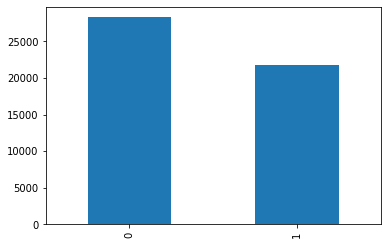

We see targets are not balanced


In [50]:
print('Tageet distribution:')
train['target'].value_counts().plot.bar()
plt.show()
print('We see targets are not balanced')

Show how the catergorical values are distributed per target


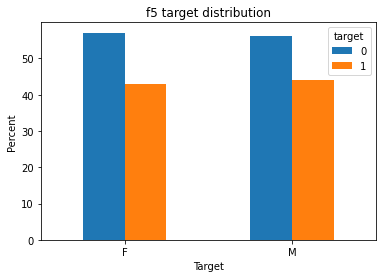

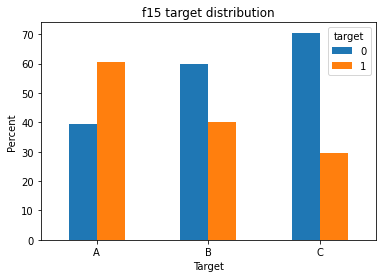

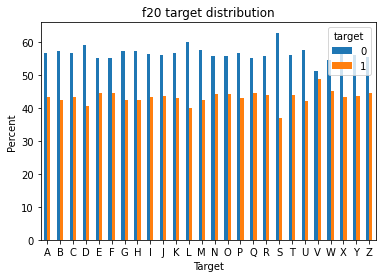

In [49]:
cat_columns = ['f5', 'f15', 'f20']

print('Show how the catergorical values are distributed per target')
for column in cat_columns:
    group = train.groupby([column, 'target'])
    percent = group.size().groupby(level=0).apply(lambda count: 100 * count / sum(count)).rename('Percent').reset_index()
    pivot = percent.pivot(column, 'target', 'Percent')

    ax = pivot.plot.bar(stacked=False, rot=0)
    plt.title(f'{column} target distribution')
    plt.ylabel('Percent')
    plt.xlabel('Target')
    plt.show()

## Data cleaning
Based on exploration we have done these steps for data cleaning. After each step we tested to see if the accuracy in a basic XGB model improved, to decide if we would include it or not

In [ ]:
# Fix 0 value noise, change to most common value in column. 
impute_0_columns = ['f3', 'f18', 'f21']

for column in impute_0_columns:
    train.loc[train[column] == 0, column] = train[column].mode() # mode() finds most common value
    test.loc[test[column] == 0, column] = test[column].mode()

# remove -1 from 'month' column f11
train.loc[train['f11'] == -1, 'f11'] = train['f11'].mode()
test.loc[test['f11'] == -1, 'f11'] = test['f11'].mode()

## Feature engineering
Similar to data cleaning, we have tested each step to see if it improves

In [ ]:
#### 1 target:
- correlations: 
    - f21-f6 has a very high correlation.
    - f25-f6
    - f26-f4
#### 0 target:
- correlations:
    - f26-f0. f26 is bool, and more are false than target 1. Target 1's f0 has very few False. 
    - f26-f6.

In [ ]:
# Conert letters to int, where A=1, B=2, etc. However, this did not improve score
# so we have not included it in the final model
for col in features_ord_alph:
    ord_order_dict = {i : j for j, i in enumerate(sorted(list(set(list(train[col].dropna().unique()) + list(test[col].dropna().unique())))))}
    train[f'{col}_en'] = train[col].fillna('NULL').map(ord_order_dict)
    test[f'{col}_en'] = test[col].fillna('NULL').map(ord_order_dict)

In [ ]:
# f6 and f21 have a high covariance for target 1, so try to make some feature out of it:
# No improvement in score
train['f6_f21'] = train['f6'].fillna(1)**2*train['f21'].fillna(1)**2
test['f6_f21'] = test['f6'].fillna(1)**2*test['f21'].fillna(1)**2

In [ ]:
# Save as above, no improvement
train['f0_f26'] = (train['f0'] == False) | (train['f26'] == False)
test['f0_f26'] = (test['f0'] == False) | (test['f26'] == False)

In [ ]:
# improves
train['f6_f0'] = train['f6'].fillna(1)**2*train['f0'].fillna(1)**2
test['f6_f0'] = test['f6'].fillna(1)**2*test['f0'].fillna(1)**2

In [ ]:
# We hypothesise column f11 describes months, from 0-11
# so add cyclical feature
def cyc_enc(df, col, max_vals):
    df[col + '_sin'] = np.sin(2 * np.pi * df[col]/max_vals)
    df[col + '_cos'] = np.cos(2 * np.pi * df[col]/max_vals)
    return df
train = cyc_enc(train, 'f11', 11)
test = cyc_enc(test, 'f11', 11)

In [ ]:
# For columns with dtype 'object' we need to represent them as numeric.
# One hot encoding gave us best result, compared to label encoding and target encoding.
train = pd.get_dummies(train, columns=ohe_columns + features_nom_high)
test = pd.get_dummies(test, columns=ohe_columns + features_nom_high)

## Modeling
We use XGBoost, CatBoos

In [82]:
# split train set into a train and test set
X = train.drop(['target'], axis=1)
y = train['target']

X_train, X_test, y_train, y_test = train_test_split(X, y)

In [ ]:
%%time

xgbmodel = XGBRegressor()

xgbmodel.fit(X_train, y_train, verbose=False)
predictions = xgbmodel.predict(X_test)
#calculate score
base_score = roc_auc_score(y_test, predictions)

In [ ]:
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score
from xgboost import plot_importance
from sklearn.metrics import make_scorer
from hyperopt import fmin, hp, tpe
import gc
import time

RANDOM_STATE = 42 # 

# Use Hyperopt to optimize xgboost parameters.
def objective(params):
    time1 = time.time()

    print("\n############## New Run ################")
    print(f"params = {params}")
    FOLDS = 5
    count=1
    kf = KFold(n_splits=FOLDS, shuffle=True) # random_state=params['random_state']

    y_preds = np.zeros(test.shape[0])
    score_mean = 0
    scal_pos_weight = len(y_train[y_train == 0]) / len(y_train[y_train == 1])
    for tr_idx, val_idx in kf.split(X_train, y_train):
        
        X_tr, X_val = X_train.iloc[tr_idx, :], X_train.iloc[val_idx, :]
        y_tr, y_val = y_train.iloc[tr_idx], y_train.iloc[val_idx]
        
        clf = XGBRegressor(
            n_estimators=300, 
            scale_pos_weight=scal_pos_weight,
            **params
        )
        clf.fit(X_tr, y_tr),

        predictions = clf.predict(X_val)
        #calculate score
        score = roc_auc_score(y_val, predictions)
        score_mean += score
        print(f'{count} CV - score: {round(score, 4)}')
        count += 1
    time2 = time.time() - time1
    print(f"Total Time Run: {round(time2 / 60,2)}")
    gc.collect()
    print(f'Mean ROC_AUC: {score_mean / FOLDS}')
    del X_tr, X_val, y_tr, y_val, clf, score
    
    return -(score_mean / FOLDS)

# https://xgboost.readthedocs.io/en/latest/parameter.html
space = {
    #'random_state': RANDOM_STATE,
    
    # The maximum depth of a tree, same as GBM.
    # Used to control over-fitting as higher depth will allow model 
    # to learn relations very specific to a particular sample.
    # Should be tuned using CV.
    # Typical values: 3-10
    'max_depth': hp.choice('max_depth', np.arange(3, 10, dtype=int)),
    
    # reg_alpha: L1 regularization term. L1 regularization encourages sparsity 
    # (meaning pulling weights to 0). It can be more useful when the objective
    # is logistic regression since you might need help with feature selection.
    'reg_alpha':  hp.uniform('reg_alpha', 0.01, 0.4),
    
    # reg_lambda: L2 regularization term. L2 encourages smaller weights, this
    # approach can be more useful in tree-models where zeroing 
    # features might not make much sense.
    'reg_lambda': hp.uniform('reg_lambda', 0.01, .4),
    
    # eta: Analogous to learning rate in GBM
    # Makes the model more robust by shrinking the weights on each step
    # Typical final values to be used: 0.01-0.2
    'learning_rate': hp.uniform('learning_rate', 0.01, 0.15),
    
    # colsample_bytree: Similar to max_features in GBM. Denotes the 
    # fraction of columns to be randomly samples for each tree.
    # Typical values: 0.5-1
    'colsample_bytree': hp.uniform('colsample_bytree', 0.3, 1),
    
    # A node is split only when the resulting split gives a positive
    # reduction in the loss function. Gamma specifies the 
    # minimum loss reduction required to make a split.
    # Makes the algorithm conservative. The values can vary depending on the loss function and should be tuned.
    'gamma': hp.uniform('gamma', 0.01, .7),
    
    # subsample: represents a fraction of the rows (observations) to be 
    # considered when building each subtree. Tianqi Chen and Carlos Guestrin
    # in their paper A Scalable Tree Boosting System recommend 
    'subsample': hp.choice('subsample', [.5, 0.6, 0.7, .8]),
    
    'min_child_weight' : hp.quniform('min_child_weight', 1, 5, 1),
    
    'eval_metric': 'auc',

}

In [ ]:
%%time
# We use hyperpot to find the best hyperparameters
# Note: takes forever
best = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            max_evals=30, 
            # trials=trials
           )
# Best parameters:
"""
**{'colsample_bytree': 0.7048862950970731,
 'gamma': 0.6870786593228237,
 'learning_rate': 0.043037814961976235,
 'max_depth': 8,
 'reg_alpha': 0.12849120484354531,
 'reg_lambda': 0.21891264474184496,
}"""

In [ ]:
# Calculate ROC curve
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

def print_roc_curve(test_y, predictions):
    fpr, tpr, _ = roc_curve(test_y, predictions)
    roc_auc = auc(fpr, tpr)
    plt.figure()
    lw = 2
    plt.plot(fpr, tpr, color='darkorange',
             lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([-0.02, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC curve')
    plt.legend(loc="lower right")
    plt.show()

print_roc_curve(y_test, predictions)

In [ ]:
%%time 
# now lets try tuning xgboost by letting it stop learning when the validation score stops improving, 
# and letting it cycle through the learning process until it does so

my_model = XGBRegressor(n_estimators=1000, learning_rate=0.05)

# fit new df to model
my_model.fit(X_train, y_train, early_stopping_rounds=5, eval_set=[(X_test, y_test)], verbose=False)
# generate predictions
predictions = my_model.predict(X_test)
#calculate score
tuned_score = roc_auc_score(y_test, predictions)
print(tuned_score)